# Dogs vs. Cats Redux: Kernels Edition

* the Kaggle data is available at
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
and has been uploaded to Amazon S3 for the sake of reproducibility

## Create necessary filestructure

In [51]:
import os

In [52]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

In [53]:
from itertools import product

In [54]:
if not os.path.exists('data'):
    print('Creating directory tree..')
    for path in product((train_data_dir, validation_data_dir),
                        ('dogs', 'cats')):
        full_path = os.path.join(path[0], path[1])
        print(full_path)
        os.makedirs(full_path, exist_ok=True)

* download the training dataset from the Amazon bucket

In [55]:
train_zip_file = 'data/train.zip'

In [56]:
if not os.path.isfile(train_zip_file):
    print('Downloading training data archive. Please wait.')
    import requests
    
    # get stream
    r = requests.get('https://s3.eu-west-2.amazonaws.com/kaggledatafiles/train.zip',
                allow_redirects=False, stream=True)
    
    # write to file
    with open(train_zip_file, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)

* validate checksum

In [57]:
import hashlib

In [58]:
def sha256_checksum(filename, block_size=65536):
    sha256 = hashlib.sha256()
    with open(filename, 'rb') as f:
        for block in iter(lambda: f.read(block_size), b''):
            sha256.update(block)
    return sha256.hexdigest()

In [59]:
correct_checksum = '36fbbfb947aeffeaf6f8ddf5178cd43d1b74aae150dff942eadb07df7929a6d7'
checksum = sha256_checksum(train_zip_file)
assert checksum == correct_checksum, 'Checksum mismatch!'
print('Checksum correct!')

Checksum correct!


* unzip the downloaded archive

In [60]:
raw_data_dir = 'data/raw'

In [61]:
if not os.path.exists(raw_data_dir):
    print('Unzipping training data archive..')
    import zipfile
    with zipfile.ZipFile(train_zip_file, 'r') as zip_ref:
        zip_ref.extractall(raw_data_dir)

## Class definitions for easy manipulation of image files

In [62]:
from collections.abc import Mapping, Sequence

In [63]:
class Pictures(Mapping):
    def __init__(self, filenames):
        self.files = filenames
        pic_list = [Picture(file) for file in filenames]
        animals = {pic.animal for pic in pic_list}
        for animal in animals:
            seq = [pic for pic in pic_list if pic.animal == animal]
            if animal == 'cat':
                cat_seq = CatSequence(seq)
            elif animal == 'dog':
                dog_seq = DogSequence(seq)
            else:
                raise NameError('Unidentified animal!')
        self._storage = {'cat':cat_seq, 'dog':dog_seq}
                
    def __getitem__(self, key):
        return self._storage[key]
    def __iter__(self):
        return iter(self._storage)
    def __len__(self):
        return len(self._storage)

    def __repr__(self):
        cname = type(self).__name__
        return "{0}({1})".format(cname, self.files)
    
    def __str__(self):
        return "\n".join(self.files)    

In [64]:
class AnimalSequence(Sequence):
    def __init__(self, list_of_pictures):

        self._storage = {pic.index:pic for pic in list_of_pictures}
        
        self._animal = {pic.animal for pic in self._storage.values()}

        # sequence must contain a single animal
        assert len(self._animal) == 1, 'Error: multi-animal sequence!'

    @property
    def files(self):
        return (pic.file for pic in self._storage.values())
    
    def __len__(self):
        return len(self._storage)
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            indices = range(*key.indices(len(self)))
            return self.__class__([self._storage[i] for i in indices])
        else: # plain index
            return self._storage[key]
    
    def __repr__(self):
        cname = type(self).__name__
        pic_list = list(self._storage.values())
        return "{0}({1})".format(cname, pic_list)
    
    def __str__(self):
        return "\n".join([pic.file for pic in self._storage.values()])

In [65]:
class CatSequence(AnimalSequence):
    def __init__(self, list_of_pictures):
        AnimalSequence.__init__(self, list_of_pictures)
        assert self._animal.pop() == 'cat', 'Expecting cats!'

In [66]:
class DogSequence(AnimalSequence):
    def __init__(self, list_of_pictures):
        AnimalSequence.__init__(self, list_of_pictures)
        assert self._animal.pop() == 'dog', 'Expecting dogs!'

In [67]:
class Picture:
    separator = '.'
    
    def __init__(self, file):
        self.file = file
    
    @property
    def animal(self):
        return self._fields()[0]
    
    @property
    def index(self):
        return int(self._fields()[1])

    @property
    def extension(self):
        return self._fields()[2]

    def _fields(self):
        return self.file.split(Picture.separator)
    
    def __repr__(self):
        cname = type(self).__name__
        return "{0}({1})".format(cname, repr(self.file))
    
    def __str__(self):
        return self.file

## Copy samples to the right folders

In [68]:
raw_train_data_dir = os.path.join(raw_data_dir, 'train')
raw_train_file_list = os.listdir(raw_train_data_dir)

In [69]:
raw_train_pics = Pictures(raw_train_file_list)

In [70]:
# 1000 training samples/class (8%)
cats_train = raw_train_pics['cat'][0:1000]
dogs_train = raw_train_pics['dog'][0:1000]

# 400 validation samples/class
cats_validation = raw_train_pics['cat'][1000:1400]
dogs_validation = raw_train_pics['dog'][1000:1400]

* copy files to right place in the directory tree

In [71]:
import shutil

In [72]:
def copy_files(lst, src, dst):
    """Copy `lst` of files from `src` folder to `dst` folder."""
    for f in lst:
        srcfile = os.path.join(src, f)
        shutil.copy(srcfile, dst)

In [73]:
print('Copying images..')
copy_files(cats_train.files, raw_train_data_dir, 
           os.path.join(train_data_dir, 'cats'))
copy_files(dogs_train.files, raw_train_data_dir, 
           os.path.join(train_data_dir, 'dogs'))

copy_files(cats_validation.files, raw_train_data_dir,
           os.path.join(validation_data_dir, 'cats'))
copy_files(dogs_validation.files, raw_train_data_dir,
           os.path.join(validation_data_dir, 'dogs'))

Copying images..


## Data exploration

In [74]:
# import matplotlib's state machine interface
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

# display matplotlib plots inside the notebook
%matplotlib inline

In [75]:
# change default colormap; color images are unaffected
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

In [76]:
from keras.preprocessing.image import load_img

In [77]:
import numpy as np

In [78]:
from skimage import io, img_as_float

In [79]:
from skimage.color import rgb2gray

In [80]:
image = io.imread('data/train/cats/cat.0.jpg')

In [81]:
print(type(image), image.dtype, image.shape)

<class 'numpy.ndarray'> uint8 (374, 500, 3)


In [82]:
image_gray = rgb2gray(image)
# save image
# io.imsave('./pano-advanced-output.png', pano_combined)

In [83]:
from skimage.transform import resize

In [84]:
image_gray = resize(image_gray, (150, 150))

In [85]:
print(type(image_gray), image_gray.dtype, image_gray.shape)

<class 'numpy.ndarray'> float64 (150, 150)


In [86]:
#imshow_all(image_gray)

In [87]:
import random

In [88]:
def sample_8_from(src_dir):
    """Samples 8 images from `src_dir` and displays them."""
    files = os.listdir(src_dir)
    sample_files = random.sample(files, 8)
    full_paths = [os.path.join(src_dir, file) for file in sample_files]
    show_8(full_paths)

* visualize a sample of the raw data

In [89]:
#sample_8_from(raw_train_data_dir)

In [90]:
# scikit-image based alternative

In [91]:
# multiple images at once
ic = io.imread_collection('data/preview/*.jpeg')

In [92]:
def imshow_all(*images, **kwargs):
    # rescale values to (0..1)
    images = [img_as_float(img) for img in images]

    # extract labels from the keywords
    labels = kwargs.pop('labels', None)
    # default to empty labels if not specified
    if labels is None:
        labels = [''] * len(images)
    # extract nrows
    nrows = kwargs.pop('nrows', None)
    if nrows is None:
        nrows = 1
    # extract ncols
    ncols = kwargs.pop('ncols', None)
    if ncols is None:
        ncols = 1
    
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))

    gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, 
                           top=1., bottom=0.,
                           right=1., left=0.,
                           hspace=0., wspace=0.,
                           **kwargs)
    
    for g, img, label in zip(gs, images, labels):
        ax = plt.subplot(g)
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)
        ax.axis('off')

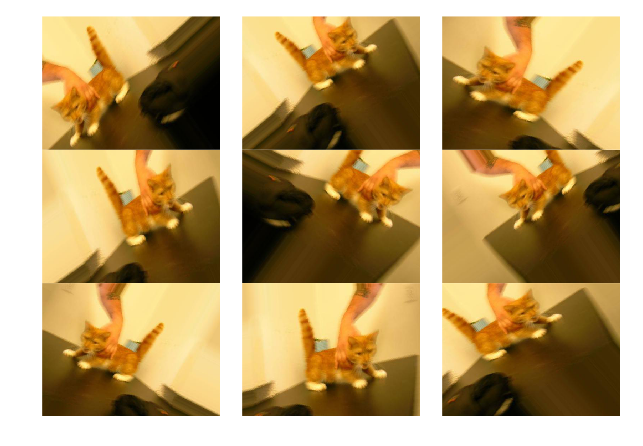

In [93]:
imshow_all(*ic[:9], nrows=3, ncols=3)

* this is both cats and dogs, which we separated into

In [94]:
# cats

In [95]:
#sample_8_from(os.path.join(train_data_dir, 'cats'))

In [97]:
# and dogs

In [98]:
#sample_8_from(os.path.join(train_data_dir, 'dogs'))

## Let Keras do its magic

In [99]:
from keras.preprocessing.image import ImageDataGenerator,\
                                   array_to_img, img_to_array

In [100]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [101]:
img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)

In [102]:
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [103]:
x.shape

(1, 374, 500, 3)

In [104]:
preview_data_dir = 'data/preview'
os.makedirs(preview_data_dir, exist_ok=True)

In [105]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=preview_data_dir, save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [107]:
#sample_8_from(preview_data_dir)

In [108]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [109]:
# dimensions of our images.
img_width, img_height = 150, 150

nb_train_samples = 2000
nb_validation_samples = 800
nb_epoch = 50

In [110]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [111]:
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [112]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [113]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [114]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_data_dir,  # this is the target directory
        target_size=(img_width, img_height),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [115]:
#model.fit_generator(
#        train_generator,
#        samples_per_epoch=nb_train_samples,
#        nb_epoch=nb_epoch,
#        validation_data=validation_generator,
#        nb_val_samples=nb_validation_samples)

In [116]:
model.load_weights('data/first_try.h5')  # always save your weights after training or during training

In [117]:
model.predict(x)

ValueError: Error when checking : expected convolution2d_input_1 to have shape (None, 150, 150, 3) but got array with shape (1, 374, 500, 3)

In [ ]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model.summary()